### AI Bootcamp - June 2024 Cohort - Analyzing and Predicting Flight Delays
Documentation and Context: See the project's ReadMe.md file for documentation on the column names and purposes.

### What's in this workbook?
This is a starter Jupyter Notebook for the project team to use when building out various machine learning models. Each team member will create a copy of this notebook for their work. 

## Libraries Imported
* Pandas
* Numpy
* Matplotlib
* sklearn
    * StandardScaler
    * PCA
    * LabelEncoder

In [323]:
# Do imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

### Read In Data to Dataframe

In [324]:
# Create DataFrame
df = pd.read_csv('./data/Airlines.csv')
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [325]:
df.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.00000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.00000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.60446,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.00000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.50000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.00000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.50000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.00000,7814.000000,7.000000,1439.000000,655.000000,1.000000


In [326]:
len(df['AirportFrom'].unique())

293

In [327]:
df['Time_encoded'] = df['Time'].apply(lambda x: f"{x // 60:02d}:{x % 60:02d}")
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Time_encoded
0,1,CO,269,SFO,IAH,3,15,205,1,00:15
1,2,US,1558,PHX,CLT,3,15,222,1,00:15
2,3,AA,2400,LAX,DFW,3,20,165,1,00:20
3,4,AA,2466,SFO,DFW,3,20,195,1,00:20
4,5,AS,108,ANC,SEA,3,30,202,0,00:30


In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            539383 non-null  int64 
 1   Airline       539383 non-null  object
 2   Flight        539383 non-null  int64 
 3   AirportFrom   539383 non-null  object
 4   AirportTo     539383 non-null  object
 5   DayOfWeek     539383 non-null  int64 
 6   Time          539383 non-null  int64 
 7   Length        539383 non-null  int64 
 8   Delay         539383 non-null  int64 
 9   Time_encoded  539383 non-null  object
dtypes: int64(6), object(4)
memory usage: 41.2+ MB


### Preprocessing : Encoding 'AirportFrom', 'AirportTo', 'Airline' Columns

In [329]:
airport_codes = df['AirportFrom'].unique()
airport_codes

array(['SFO', 'PHX', 'LAX', 'ANC', 'LAS', 'SLC', 'DEN', 'ONT', 'FAI',
       'BQN', 'PSE', 'HNL', 'BIS', 'IYK', 'EWR', 'BOS', 'MKE', 'GFK',
       'OMA', 'GSO', 'LMT', 'SEA', 'MCO', 'TPA', 'DLH', 'MSP', 'FAR',
       'MFE', 'MSY', 'VPS', 'BWI', 'MAF', 'LWS', 'RST', 'ALB', 'DSM',
       'CHS', 'MSN', 'JAX', 'SAT', 'PNS', 'BHM', 'LIT', 'SAV', 'BNA',
       'ICT', 'ECP', 'DHN', 'MGM', 'CAE', 'PWM', 'ACV', 'EKO', 'PHL',
       'ATL', 'PDX', 'RIC', 'BTR', 'HRL', 'MYR', 'TUS', 'SBN', 'CAK',
       'TVC', 'CLE', 'ORD', 'DAY', 'MFR', 'BTV', 'TLH', 'TYS', 'DFW',
       'FLL', 'AUS', 'CHA', 'CMH', 'LRD', 'BRO', 'CRP', 'LAN', 'PVD',
       'FWA', 'JFK', 'LGA', 'OKC', 'PIT', 'PBI', 'ORF', 'DCA', 'AEX',
       'SYR', 'SHV', 'VLD', 'BDL', 'FAT', 'BZN', 'RDM', 'LFT', 'IPL',
       'EAU', 'ERI', 'BUF', 'IAH', 'MCI', 'AGS', 'ABI', 'GRR', 'LBB',
       'CLT', 'LEX', 'MBS', 'MOD', 'AMA', 'SGF', 'AZO', 'ABE', 'SWF',
       'BGM', 'AVP', 'FNT', 'GSP', 'ATW', 'ITH', 'TUL', 'COS', 'ELP',
       'ABQ', 'SMF',

### Make a copy of Dataframe for preprocessing

In [330]:
encoded_df = df.copy()

In [331]:
unique_codes = encoded_df['AirportFrom'].unique()
code_to_id = {code: idx for idx, code in enumerate(unique_codes, start=1)}

# Apply the mapping to create a new column with unique IDs
encoded_df['AirportFroIDs'] = encoded_df['AirportFrom'].map(code_to_id)
encoded_df['AirportToIDs'] = encoded_df['AirportTo'].map(code_to_id)

encoded_df

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Time_encoded,AirportFroIDs,AirportToIDs
0,1,CO,269,SFO,IAH,3,15,205,1,00:15,1,103
1,2,US,1558,PHX,CLT,3,15,222,1,00:15,2,109
2,3,AA,2400,LAX,DFW,3,20,165,1,00:20,3,72
3,4,AA,2466,SFO,DFW,3,20,195,1,00:20,1,72
4,5,AS,108,ANC,SEA,3,30,202,0,00:30,4,22
...,...,...,...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0,23:59,194,229
539379,539380,FL,398,SEA,ATL,5,1439,305,0,23:59,22,55
539380,539381,FL,609,SFO,MKE,5,1439,255,0,23:59,1,17
539381,539382,UA,78,HNL,SFO,5,1439,313,1,23:59,12,1


In [332]:
# Get unique airline codes
unique_airlines = encoded_df['Airline'].unique()

# Create a random mapping for each unique airline code
random.seed(42)  # Set a seed for reproducibility, remove if you want different random results each time
airline_to_id = {airline: random.randint(1000, 9999) for airline in unique_airlines}

# Apply the random mapping to the airline column
encoded_df['airline_id'] = encoded_df['Airline'].map(airline_to_id)

encoded_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Time_encoded,AirportFroIDs,AirportToIDs,airline_id
0,1,CO,269,SFO,IAH,3,15,205,1,00:15,1,103,2824
1,2,US,1558,PHX,CLT,3,15,222,1,00:15,2,109,1409
2,3,AA,2400,LAX,DFW,3,20,165,1,00:20,3,72,5506
3,4,AA,2466,SFO,DFW,3,20,195,1,00:20,1,72,5506
4,5,AS,108,ANC,SEA,3,30,202,0,00:30,4,22,5012


In [333]:
len(encoded_df["AirportFrom"].unique())

293

In [334]:
len(encoded_df["AirportTo"].unique())

293

In [335]:
# Drop all the categorical columns
encoded_df = encoded_df.drop(columns=['Airline', 'AirportFrom', 'AirportTo'])
encoded_df.head()

,id,Flight,DayOfWeek,Time,Length,Delay,Time_encoded,AirportFroIDs,AirportToIDs,airline_id
0,1,269,3,15,205,1,00:15,1,103,2824
1,2,1558,3,15,222,1,00:15,2,109,1409
2,3,2400,3,20,165,1,00:20,3,72,5506
3,4,2466,3,20,195,1,00:20,1,72,5506
4,5,108,3,30,202,0,00:30,4,22,5012


In [336]:
# Drop unused columns

encoded_df = encoded_df.copy()
encoded_df.drop(['id', 'Time_encoded'], axis=1, inplace=True)


In [337]:
X = encoded_df.copy()
X.drop('Delay', axis=1, inplace=True)
X.head()

,Flight,DayOfWeek,Time,Length,AirportFroIDs,AirportToIDs,airline_id
0,269,3,15,205,1,103,2824
1,1558,3,15,222,2,109,1409
2,2400,3,20,165,3,72,5506
3,2466,3,20,195,1,72,5506
4,108,3,30,202,4,22,5012


In [338]:
y = df['Delay']

In [339]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Scale the Data
SVM, KNN, K-Means, and PCA need scaling

In [340]:
# Scaling the X data by using StandardScaler()
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-1.09447296,  1.08199271,  0.01063145, ...,  1.82992654,
        -1.05211002, -0.75328146],
       [ 2.01121043, -1.00719177,  1.00286384, ...,  2.43184152,
        -0.19638348,  2.16454157],
       [-0.8346985 ,  0.55969659, -0.35246809, ..., -1.21132809,
        -0.38654493, -1.26398092],
       ...,
       [ 0.14828415, -1.00719177, -1.26920454, ...,  0.8636946 ,
        -0.83025499,  0.04212289],
       [ 1.46021769, -0.48489565, -0.83779915, ..., -0.37181509,
        -0.76686784, -1.21934498],
       [ 0.77038833, -0.48489565, -0.22664152, ...,  0.89537434,
        -0.19638348,  0.10405023]])

In [341]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-1.13268931,  0.03740047, -0.99957617, ..., -1.21132809,
        -0.35485136, -1.26398092],
       [-0.45737249, -0.48489565, -1.44895678, ...,  0.3726587 ,
        -0.87779535, -0.11872733],
       [ 0.77232333,  0.55969659,  0.52831791, ...,  0.10338094,
        -0.37069815, -0.85582348],
       ...,
       [ 1.25752589, -1.52948788, -1.59275858, ...,  1.03793315,
        -0.37069815, -1.21934498],
       [ 0.59527036,  1.60428882,  1.08554987, ..., -1.21132809,
         0.94458524, -0.11872733],
       [-0.66054803,  0.55969659, -0.04688927, ..., -0.0708576 ,
         0.07301191, -0.50919125]])

### SVM

In [342]:
# Create the support vector machine classifier model
svc_model = SVC(kernel='linear', max_iter=10000)

In [343]:
svc_model.fit(X_train_scaled, y_train)

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=10000)

In [344]:
# Validate the model by checking the model accuracy with model.score
svc_train_score = svc_model.score(X_train_scaled, y_train) 
print(f'The SVC training score is: {svc_train_score}')
svc_test_score = svc_model.score(X_test_scaled, y_test)
print(f'The SVC testing score is: {svc_test_score}') 

The SVC training score is: 0.44740777728613207
The SVC testing score is: 0.44729543330910815


### Random Forest

In [345]:
# Create and train a randomforest model
random_model = RandomForestClassifier(n_estimators=500, max_depth=5)
random_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500)

In [346]:
# Check the model's balanced accuracy on the TEST set
y_test_pred = random_model.predict(X_test)
ran_test_bal_score = balanced_accuracy_score(y_test, y_test_pred) 
print(ran_test_bal_score)
# print(balanced_accuracy_score(y_test, y_test_pred))

0.6062716100203527


In [347]:
# Check the model's balanced accuracy on the training set
y_train_pred = random_model.predict(X_train)
ran_train_bal_score = balanced_accuracy_score(y_train, y_train_pred)
print(ran_train_bal_score)
# print(balanced_accuracy_score(y_train, y_train_pred))

0.6061436764493637


### Logistic Regression

In [348]:
# Create a LogisticRegression function
logistic_regression_model = LogisticRegression(max_iter=1000)

In [349]:
# Fit the model for Logistic Regression
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [350]:
# Score the model
print(f'The training data score: {logistic_regression_model.score(X_train, y_train)}')
print(f'The testing data score: {logistic_regression_model.score(X_test, y_test)}')
      

The training data score: 0.5694584178950257
The testing data score: 0.5707622028091304


In [351]:
# Generate predictions from the model we just fit
log_predictions = logistic_regression_model.predict(X_train)

# Convert those predictions (and actual values) to a DataFrame
log_results_df = pd.DataFrame({'Prediction': log_predictions, 'Actual': y_train})

In [352]:
# Apply the fitted model to the test dataset
log_testing_predictions = logistic_regression_model.predict(X_test)

# Save both the test predictions and actual test values to a DataFrame
log_results_df = pd.DataFrame({
    "Testing Data Predictions": log_testing_predictions, 
    "Testing Data Actual Targets": y_test})

In [353]:
# Display the results DataFrame
log_results_df.head()

,Testing Data Predictions,Testing Data Actual Targets
21403,0,0
121631,0,1
535153,0,1
415037,0,0
69899,0,0


In [354]:
# Import the accuracy score function
from sklearn.metrics import accuracy_score

# Calculate the model's accuracy on the test dataset
log_accuracy_score = accuracy_score(y_test, log_testing_predictions)
log_accuracy_score

0.5707622028091304

### Summary for All Models

In [355]:
print("SVC")
print(f'SVC testing accuracy score: {svc_test_score}')
print(f'SVC training accuracy score: {svc_train_score}')
print("*" * 20)
print("RANDOM FOREST")
print(f'Random Forest test accuracy score: {ran_test_bal_score}')
print(f'Random Forest training accuracy score: {ran_train_bal_score}')
print("*" * 20)
print("LOGISTIC REGRESSION")
print(f'LogisticRegression accuracy score: {log_accuracy_score}')

SVC
SVC testing accuracy score: 0.44729543330910815
SVC training accuracy score: 0.44740777728613207
********************
RANDOM FOREST
Random Forest test accuracy score: 0.6062716100203527
Random Forest training accuracy score: 0.6061436764493637
********************
LOGISTIC REGRESSION
LogisticRegression accuracy score: 0.5707622028091304


## KMeans 
### 1. Elbow Method
### 2. Implement KMeans Model

In [356]:
# Make A Copy Of 'encoded_df' Dataframe
k_df = encoded_df.copy()

### 1. Implementing Elbow Method

In [357]:
# Create an empty list to store the inertia values
inertia = []

# Create a list with the number of k-values to try
k = list(range(1, 11))

# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, n_init='auto', random_state=0)
    k_model.fit(k_df)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow

,k,inertia
0,1,5.687787e+12
1,2,2.733911e+12
2,3,1.754654e+12
3,4,1.282218e+12
4,5,8.419364e+11
5,6,5.589850e+11
6,7,5.166877e+11
7,8,4.751974e+11
8,9,3.717845e+11
9,10,3.279520e+11


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

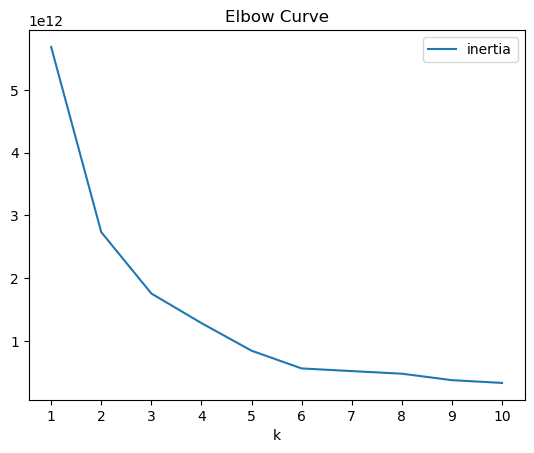

In [358]:
# Plot the Elbow curve
df_elbow.plot.line(x="k",
                   y="inertia",
                   title="Elbow Curve",
                   xticks=k)

In [359]:
# Determine the rate of decrease between each k value. 
k = elbow_data["k"]
inertia = elbow_data["inertia"]
for i in range(1, len(k)):
    percentage_decrease = (inertia[i-1] - inertia[i]) / inertia[i-1] * 100
    print(f"Percentage decrease from k={k[i-1]} to k={k[i]}: {percentage_decrease:.2f}%")

Percentage decrease from k=1 to k=2: 51.93%
Percentage decrease from k=2 to k=3: 35.82%
Percentage decrease from k=3 to k=4: 26.92%
Percentage decrease from k=4 to k=5: 34.34%
Percentage decrease from k=5 to k=6: 33.61%
Percentage decrease from k=6 to k=7: 7.57%
Percentage decrease from k=7 to k=8: 8.03%
Percentage decrease from k=8 to k=9: 21.76%
Percentage decrease from k=9 to k=10: 11.79%


In [360]:
# Define the model with 6 clusters
model = KMeans(n_clusters=6, n_init='auto', random_state=3)

# Fit the model
model.fit(k_df)

# Make predictions
original_kmeans_predictions = model.predict(k_df)

# Elbow Data Results
* ### Optimal Number For K = 6
    * The optimal number was chosen based on the significant drop that occures from k6 to k7, which indicates adding more clusters beyond 6 does not reduces the intertia which determines how well the clusters are formed.

### Segment The Data With KMeans Using The Optimal Number

In [361]:
k_df.head()

,Flight,DayOfWeek,Time,Length,Delay,AirportFroIDs,AirportToIDs,airline_id
0,269,3,15,205,1,1,103,2824
1,1558,3,15,222,1,2,109,1409
2,2400,3,20,165,1,3,72,5506
3,2466,3,20,195,1,1,72,5506
4,108,3,30,202,0,4,22,5012


In [362]:
# Define the model with 6 clusters
model = KMeans(n_clusters=6, n_init='auto', random_state=42)

# Fit the model
model.fit(k_df)

# Make predictions
original_KMean_predictions = model.predict(k_df)

### Scale The Data Using StandardScaler()
---
- Apply the StandardScaler() to the entire dataframe

In [363]:
# Make a copy of the dataframe
means_df = encoded_df.copy()

# Scale the dataframe
means_scaled_df = StandardScaler().fit_transform(means_df)

# Review the scaled data
means_scaled_df

array([[-1.04425823, -0.48555175, -2.83309217, ..., -1.22670754,
         0.38856732, -0.69420515],
       [-0.42077821, -0.48555175, -2.83309217, ..., -1.21086826,
         0.48357834, -1.26337745],
       [-0.01350888, -0.48555175, -2.81510951, ..., -1.19502899,
        -0.10232293,  0.38460765],
       ...,
       [-0.87980268,  0.55901871,  2.28836894, ..., -1.22670754,
        -0.97325726,  1.90226638],
       [-1.13664356,  0.55901871,  2.28836894, ..., -1.05247552,
        -1.22661998,  0.01293613],
       [-0.47688658,  0.55901871,  2.28836894, ..., -1.19502899,
        -0.38735599, -1.26337745]])

In [364]:
means_scaled_df = pd.DataFrame(means_scaled_df, columns=[['Flight', 'DayOfWeek', 'Time', 'Length', 'Delay', 'AirportFroIDs',
       'AirportToIDs', 'airline_id']])
means_scaled_df

,Flight,DayOfWeek,Time,Length,Delay,AirportFroIDs,AirportToIDs,airline_id
0,-1.044258,-0.485552,-2.833092,1.038237,1.115778,-1.226708,0.388567,-0.694205
1,-0.420778,-0.485552,-2.833092,1.280689,1.115778,-1.210868,0.483578,-1.263377
2,-0.013509,-0.485552,-2.815110,0.467761,1.115778,-1.195029,-0.102323,0.384608
3,0.018415,-0.485552,-2.815110,0.895618,1.115778,-1.226708,-0.102323,0.384608
4,-1.122133,-0.485552,-2.779144,0.995451,-0.896236,-1.179190,-0.894081,0.185900
...,...,...,...,...,...,...,...,...
539378,-1.088274,0.559019,2.288369,2.763925,-0.896236,1.830272,2.383799,-0.694205
539379,-0.981862,0.559019,2.288369,2.464425,-0.896236,-0.894083,-0.371521,1.902266
539380,-0.879803,0.559019,2.288369,1.751331,-0.896236,-1.226708,-0.973257,1.902266
539381,-1.136644,0.559019,2.288369,2.578520,1.115778,-1.052476,-1.226620,0.012936


### Use The Elbow Method To Determine The Optimal Number Of Clusters 

In [365]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Create a for loop to compute the inertia with each possible value of k and add the values to the inertia list.
for i in k:
    model = KMeans(n_clusters=i, n_init='auto', random_state=42)
    model.fit(means_scaled_df)
    inertia.append(model.inertia_)

# Create a dictionary with the data to plot the elbow curve
elbow_data = {
    "k": k,
    "inertia": inertia
}

# Create a DataFrame with the data to plot the elbow curve
df_elbow = pd.DataFrame(elbow_data)

# Display the DataFrame
df_elbow

,k,inertia
0,1,4.315064e+06
1,2,3.791173e+06
2,3,3.286480e+06
3,4,2.998946e+06
4,5,2.832850e+06
5,6,2.688803e+06
6,7,2.569696e+06
7,8,2.456414e+06
8,9,2.352535e+06
9,10,2.266165e+06


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

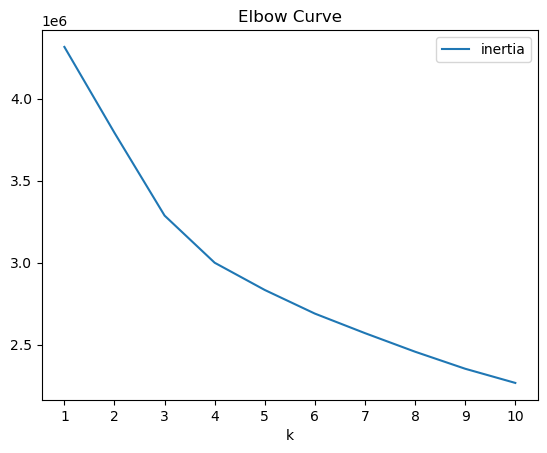

In [366]:
# Plot the Elbow curve
df_elbow.plot.line(x="k",
                   y="inertia",
                   title="Elbow Curve",
                   xticks=k)

In [367]:
# Determine the rate of decrease between each k value. 
k = elbow_data["k"]
inertia = elbow_data["inertia"]
for i in range(1, len(k)):
    percentage_decrease = (inertia[i-1] - inertia[i]) / inertia[i-1] * 100
    print(f"Percentage decrease from k={k[i-1]} to k={k[i]}: {percentage_decrease:.2f}%")

Percentage decrease from k=1 to k=2: 12.14%
Percentage decrease from k=2 to k=3: 13.31%
Percentage decrease from k=3 to k=4: 8.75%
Percentage decrease from k=4 to k=5: 5.54%
Percentage decrease from k=5 to k=6: 5.08%
Percentage decrease from k=6 to k=7: 4.43%
Percentage decrease from k=7 to k=8: 4.41%
Percentage decrease from k=8 to k=9: 4.23%
Percentage decrease from k=9 to k=10: 3.67%


### Elbow curve suggest that the optimal number for k is 3
The rate of decrease in inertia **begins** to slow down between k=3 and k=4, which means that our elbow point is at k=3.

In [368]:
# Define the model with 3 clusters
model = KMeans(n_clusters=3, n_init='auto', random_state=42)

# Fit the model
model.fit(means_scaled_df)

# Make predictions
kmeans_scaled_predictions = model.predict(means_scaled_df)

In [369]:
# Import the Birch and AgglomerativeClustering modules from SKLearn
from sklearn.cluster import AgglomerativeClustering, Birch
from sklearn.decomposition import PCA


In [370]:
# Reduce dimensions using PCA before clustering
pca = PCA(n_components=2)  # Set n_components to a smaller number based on your analysis
reduced_data = pca.fit_transform(means_scaled_df)

In [371]:
from sklearn.cluster import MiniBatchKMeans

# Fit a MiniBatchKMeans model as an alternative
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=100)
kmeans_batch_predictions = kmeans.fit_predict(means_scaled_df)

In [372]:
# Create a copy of the preprocessed data
airline_predictions_df = encoded_df.copy()
# Add class columns with the labels to the new DataFrame
airline_predictions_df["original-kmeans-segments"] = original_KMean_predictions
airline_predictions_df["scaled-kmeans-segments"] = kmeans_scaled_predictions
airline_predictions_df["batch-segments"] = kmeans_batch_predictions
airline_predictions_df[['original-kmeans-segments','scaled-kmeans-segments', 'batch-segments']].head(3)

,original-kmeans-segments,scaled-kmeans-segments,batch-segments
0,0,0,2
1,0,0,2
2,1,0,2


<Axes: xlabel='Time', ylabel='Length'>

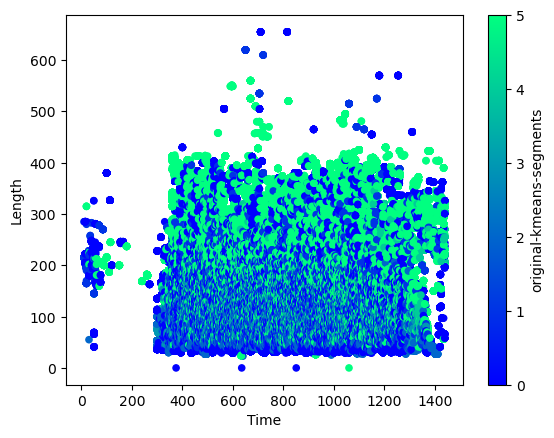

In [373]:
# Plot the kmeans clusters using the limit_bal and age columns. 
airline_predictions_df.plot.scatter(
    x="Time",
    y="Length",
    c="original-kmeans-segments",
    colormap="winter")

<Axes: xlabel='Time', ylabel='Length'>

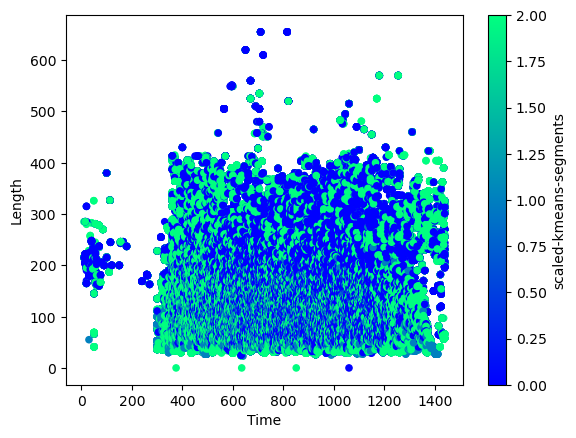

In [374]:
# Plot the kmeans clusters using the limit_bal and age columns. 
airline_predictions_df.plot.scatter(
    x="Time",
    y="Length",
    c="scaled-kmeans-segments",
    colormap="winter")

<Axes: xlabel='Time', ylabel='Length'>

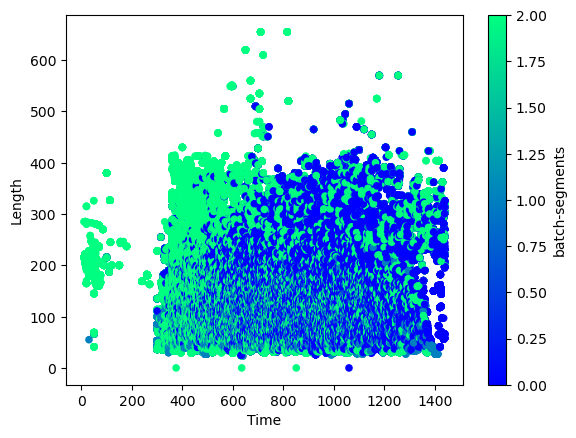

In [375]:
# Plot the kmeans clusters using the limit_bal and age columns. 
airline_predictions_df.plot.scatter(
    x="Time",
    y="Length",
    c="batch-segments",
    colormap="winter")

## Scoring The Models

In [376]:
# Create a list to store values and the values of k
score_original_k = []
score_scaled_k = []
score_batch = []

# Create a list to set the range of k values to test
k = list(range(2, 11))

In [377]:
from sklearn import metrics
# For each model, we iterate through the different cluster count (`i`). 
# Then, calculate the variance ratio for each algorithm, given that specified cluster count.

for i in k:
    # Original Kmeans variance and score
    k_model = KMeans(n_clusters=i, n_init='auto',random_state=0)
    k_model.fit(k_df)
    labels = k_model.labels_
    score = metrics.calinski_harabasz_score(k_df, labels)    
    score_original_k.append(score)
    
    # Scaled KMeans variance and score
    # Define the model with 3 clusters
    model = KMeans(n_clusters=3, n_init='auto', random_state=42)
    # Fit the model
    model.fit(means_scaled_df)
    labels = model.labels_
    score = metrics.calinski_harabasz_score(means_scaled_df, labels)    
    score_scaled_k.append(score)    
    
    # Birch variance and score
    kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=100)
    kmeans_batch_predictions = kmeans.fit_predict(means_scaled_df)
    labels = kmeans.labels_
    score = metrics.calinski_harabasz_score(means_scaled_df, labels)    
    score_batch.append(score)

In [378]:
# Display the scores. 
display(score_original_k)
display(score_scaled_k)
display(score_batch)

[582778.5451357001,
 604522.299597783,
 617749.8695705234,
 776112.5813377509,
 989794.7063558172,
 899710.0759374282,
 845228.3117550451,
 964037.908959661,
 979469.8648509125]

[84406.06978515885,
 84406.06978515885,
 84406.06978515885,
 84406.06978515885,
 84406.06978515885,
 84406.06978515885,
 84406.06978515885,
 84406.06978515885,
 84406.06978515885]

[77894.68483747238,
 77894.68483747238,
 77894.68483747238,
 77894.68483747238,
 77894.68483747238,
 77894.68483747238,
 77894.68483747238,
 77894.68483747238,
 77894.68483747238]

In [379]:
# Setup X and y variables
X = means_scaled_df.drop(columns='Delay')
y = means_scaled_df['Delay'].values.reshape(-1,1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
X_train.describe()

/var/folders/j8/8fz1pphj3d18kslnjh7scn_00000gn/T/ipykernel_96319/2871399304.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = means_scaled_df.drop(columns='Delay')


,Flight,DayOfWeek,Time,Length,AirportFroIDs,AirportToIDs,airline_id
count,404537.000000,404537.000000,404537.000000,404537.000000,404537.000000,404537.000000,404537.000000
mean,0.000209,0.000629,0.001373,0.000622,0.001434,0.000340,-0.000082
std,1.000014,1.000064,1.000429,1.001095,1.000725,1.000254,1.000634
min,-1.173888,-1.530122,-2.851075,-1.885450,-1.226708,-1.226620,-1.263377
25%,-0.829982,-1.007837,-0.855000,-0.730237,-0.878244,-0.878246,-0.752530
50%,-0.299371,0.036733,-0.024201,-0.245333,-0.197155,-0.197334,-0.117792
75%,0.638025,0.559019,0.835370,0.424976,0.769041,0.768611,0.185900
max,2.605204,1.603589,2.288369,7.456086,3.398360,3.397250,2.166137


### Missing Values

In [380]:
# Find the percentage of null values in each column
X_train.isna().sum()/len(X_train)

Flight           0.0
DayOfWeek        0.0
Time             0.0
Length           0.0
AirportFroIDs    0.0
AirportToIDs     0.0
airline_id       0.0
dtype: float64

<Axes: ylabel='Frequency'>

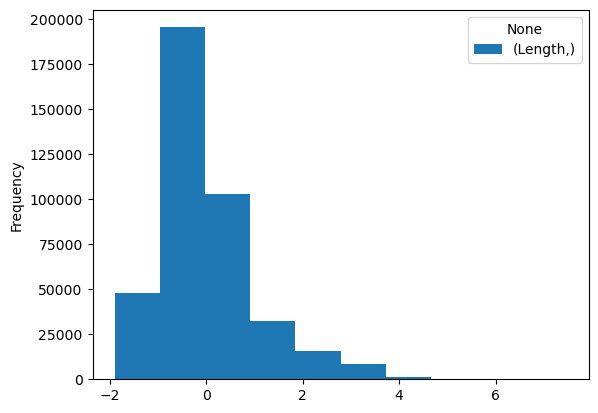

In [381]:
# Next is pdays
# This column says how many days it has been since the last 
# marketing contact for this client

X_train['Length'].plot(kind='hist')

## Re-Encode Categorical Variables 
* ### This strategy does not feed the model the significance between the to and fro airports as they will have different id's in each column, which leaves it up to the model. 

In [382]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Time_encoded
0,1,CO,269,SFO,IAH,3,15,205,1,00:15
1,2,US,1558,PHX,CLT,3,15,222,1,00:15
2,3,AA,2400,LAX,DFW,3,20,165,1,00:20
3,4,AA,2466,SFO,DFW,3,20,195,1,00:20
4,5,AS,108,ANC,SEA,3,30,202,0,00:30


In [383]:
# Set up X and Y variable
X = df.drop(columns=['Delay', 'Time_encoded'])
y = df['Delay'].values.reshape(-1,1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
X_train.describe()

,id,Flight,DayOfWeek,Time,Length
count,404537.000000,404537.000000,404537.000000,404537.000000,404537.000000
mean,269703.503803,2428.359945,3.930872,803.110769,132.245599
std,155660.127116,2067.457749,1.914785,278.164967,70.193709
min,1.000000,1.000000,1.000000,10.000000,0.000000
25%,134888.000000,712.000000,2.000000,565.000000,81.000000
50%,269974.000000,1809.000000,4.000000,796.000000,115.000000
75%,404459.000000,3747.000000,5.000000,1035.000000,162.000000
max,539383.000000,7814.000000,7.000000,1439.000000,655.000000


In [384]:
X_train['Airline'].unique()

array(['XE', 'CO', 'MQ', 'US', 'OH', 'UA', 'WN', 'DL', 'AA', 'AS', 'OO',
       '9E', 'EV', 'FL', 'HA', 'B6', 'YV', 'F9'], dtype=object)

In [385]:
# Import OneHotEncoder and OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

### Use OneHotEncoder | OrdinalEncoder to encode categorical data -- separating airport ID's

In [386]:
# This is ordinal! Lets use the ordinal encoder
# We'll set any unknown values to -1
encode_airline = OrdinalEncoder(categories=[['XE', 'CO', 'MQ', 'US', 'OH', 'UA', 'WN', 'DL', 'AA', 'AS', 'OO',
       '9E', 'EV', 'FL', 'HA', 'B6', 'YV', 'F9']], handle_unknown='use_encoded_value', unknown_value=-1)

# Train the encoder
encode_airline.fit(X_train['Airline'].values.reshape(-1, 1))

OrdinalEncoder(categories=[['XE', 'CO', 'MQ', 'US', 'OH', 'UA', 'WN', 'DL',
                            'AA', 'AS', 'OO', '9E', 'EV', 'FL', 'HA', 'B6',
                            'YV', 'F9']],
               handle_unknown='use_encoded_value', unknown_value=-1)

In [387]:
encode_airport_from = OrdinalEncoder(categories=[['IAH', 'MSP', 'OMA', 'IND', 'ORD', 'PIT', 'DTW', 'BNA', 'LGA',
       'TUS', 'KTN', 'SEA', 'DFW', 'ATL', 'MEM', 'SFO', 'DCA', 'DAY',
       'RDU', 'CLT', 'LAX', 'PHX', 'MCI', 'PDX', 'ISP', 'JAX', 'BUR',
       'JAN', 'TYS', 'EWR', 'PBI', 'DEN', 'SAT', 'BOS', 'EYW', 'SJC',
       'HNL', 'FSD', 'SMF', 'GEG', 'DAL', 'MDW', 'HRL', 'LGB', 'TPA',
       'ABQ', 'SGF', 'CAE', 'AUS', 'SAN', 'SJU', 'ONT', 'MSY', 'SLC',
       'BWI', 'MCO', 'LAS', 'ORF', 'JFK', 'MSO', 'DSM', 'SNA', 'VPS',
       'PSP', 'BDL', 'IAD', 'OKC', 'AEX', 'LIH', 'ATW', 'BHM', 'DAB',
       'TUL', 'PHF', 'BMI', 'CAK', 'COS', 'FLL', 'CLE', 'RNO', 'LIT',
       'OGG', 'MIA', 'ELP', 'ALB', 'CRP', 'PHL', 'ICT', 'OAK', 'ANC',
       'MKE', 'MYR', 'SGU', 'ROC', 'FCA', 'CRW', 'RSW', 'STL', 'CMH',
       'LWS', 'BUF', 'RIC', 'CMI', 'ACY', 'HOU', 'ECP', 'SBP', 'KOA',
       'PVD', 'MLI', 'MHT', 'CID', 'FWA', 'MLU', 'FAT', 'RAP', 'BTR',
       'LNK', 'GSO', 'MOD', 'BTV', 'CHS', 'RDM', 'SYR', 'PNS', 'CVG',
       'MOB', 'GJT', 'AVL', 'TLH', 'XNA', 'COD', 'FNT', 'PIH', 'SDF',
       'SPS', 'LFT', 'BOI', 'GRB', 'MRY', 'GRR', 'EVV', 'SMX', 'AZO',
       'ITO', 'FAR', 'GSP', 'ACV', 'MBS', 'AGS', 'SBA', 'BZN', 'PWM',
       'DRO', 'HPN', 'LBB', 'FAY', 'TVC', 'ABE', 'PIA', 'SRQ', 'OAJ',
       'ROA', 'SHV', 'SBN', 'HDN', 'MGM', 'HSV', 'DLH', 'TOL', 'PSG',
       'SUN', 'CWA', 'TWF', 'AMA', 'ABI', 'AVP', 'MSN', 'JNU', 'MFR',
       'MTJ', 'ADQ', 'BFL', 'PSE', 'CSG', 'GTR', 'ASE', 'LCH', 'LRD',
       'LMT', 'HTS', 'MDT', 'MFE', 'CIC', 'WRG', 'LEX', 'CHA', 'LAN',
       'BIS', 'MAF', 'GTF', 'EKO', 'CEC', 'IDA', 'MEI', 'MHK', 'ITH',
       'BIL', 'IYK', 'MOT', 'COU', 'GRK', 'GUC', 'RDD', 'CDV', 'DHN',
       'BET', 'HLN', 'PSC', 'SAV', 'ERI', 'ILM', 'TRI', 'FLG', 'EGE',
       'LSE', 'OTZ', 'CPR', 'YUM', 'CMX', 'PIE', 'TXK', 'EAU', 'FSM',
       'SCC', 'SCE', 'EUG', 'ELM', 'JAC', 'FAI', 'OME', 'LWB', 'VLD',
       'GPT', 'EWN', 'GGG', 'CLD', 'MKG', 'SWF', 'RKS', 'MLB', 'GNV',
       'ROW', 'BRO', 'TYR', 'ABY', 'LYH', 'CHO', 'BTM', 'BKG', 'MMH',
       'RST', 'GFK', 'PAH', 'SPI', 'STX', 'GCC', 'SAF', 'TEX', 'STT',
       'PLN', 'BQN', 'BRW', 'IPL', 'UTM', 'MQT', 'CLL', 'CYS', 'ACT',
       'BLI', 'OTH', 'SIT', 'YAK', 'BGM', 'CDC', 'BQK', 'DBQ', 'FLO',
       'BGR', 'SJT', 'ADK', 'GUM', 'ABR']])

# Train the encoder
encode_airport_from.fit(X_train['AirportFrom'].values.reshape(-1, 1))

OrdinalEncoder(categories=[['IAH', 'MSP', 'OMA', 'IND', 'ORD', 'PIT', 'DTW',
                            'BNA', 'LGA', 'TUS', 'KTN', 'SEA', 'DFW', 'ATL',
                            'MEM', 'SFO', 'DCA', 'DAY', 'RDU', 'CLT', 'LAX',
                            'PHX', 'MCI', 'PDX', 'ISP', 'JAX', 'BUR', 'JAN',
                            'TYS', 'EWR', ...]])

In [388]:
encode_airport_to = OrdinalEncoder(categories=[['MCI', 'DEN', 'LGA', 'EWR', 'CLT', 'DTW', 'GRR', 'PHL', 'MIA',
       'ATL', 'ORD', 'WRG', 'SMF', 'IND', 'SBP', 'TRI', 'CHS', 'CVG',
       'MSP', 'MCO', 'MDW', 'AUS', 'SAN', 'BHM', 'SLC', 'SFO', 'DCA',
       'MEM', 'FAT', 'LAS', 'ABI', 'BWI', 'OAK', 'DFW', 'HNL', 'CAK',
       'SNA', 'OGG', 'BUR', 'PDX', 'DAL', 'ICT', 'BDL', 'IAH', 'SDF',
       'HOU', 'GRB', 'JFK', 'BIL', 'ONT', 'MSO', 'RDU', 'OMA', 'IAD',
       'PHX', 'LAX', 'SEA', 'TUL', 'ATW', 'OKC', 'SAT', 'ALB', 'MKE',
       'BNA', 'XNA', 'FLL', 'ISP', 'MHK', 'BQK', 'BOS', 'CAE', 'CMH',
       'LIT', 'ITO', 'STL', 'SJU', 'PIT', 'BIS', 'ABQ', 'PHF', 'LEX',
       'GEG', 'ELP', 'MAF', 'SJC', 'MSY', 'TPA', 'FCA', 'FAY', 'GPT',
       'MLB', 'DSM', 'OTH', 'RNO', 'ACV', 'MFE', 'MHT', 'GJT', 'TUS',
       'PBI', 'HRL', 'MKG', 'FAR', 'JAX', 'LGB', 'MBS', 'RDM', 'SBN',
       'TYS', 'MRY', 'RSW', 'ROC', 'HDN', 'CLE', 'MSN', 'GSP', 'PVD',
       'FSM', 'FAI', 'COS', 'VPS', 'BQN', 'STT', 'LSE', 'EUG', 'TLH',
       'ROA', 'PWM', 'CRW', 'SBA', 'HLN', 'BUF', 'PIA', 'BOI', 'RIC',
       'KOA', 'CLD', 'MLI', 'LFT', 'DAY', 'BZN', 'PNS', 'RDD', 'FNT',
       'MOB', 'AMA', 'JAN', 'HSV', 'PSP', 'ANC', 'LBB', 'CHA', 'ORF',
       'MGM', 'BTV', 'CID', 'MQT', 'SMX', 'CRP', 'SAV', 'MYR', 'LMT',
       'CEC', 'AVL', 'SCE', 'HPN', 'LIH', 'MFR', 'FSD', 'SPI', 'AEX',
       'SAF', 'SRQ', 'TVC', 'ASE', 'BTR', 'MDT', 'GFK', 'RAP', 'GSO',
       'MOD', 'DLH', 'JNU', 'ERI', 'SWF', 'FWA', 'EAU', 'BMI', 'CMI',
       'SHV', 'RKS', 'IDA', 'SYR', 'CWA', 'GNV', 'IYK', 'ILM', 'MOT',
       'PSE', 'COD', 'MTJ', 'CIC', 'EVV', 'SGF', 'AGS', 'PSG', 'LRD',
       'DRO', 'AVP', 'ITH', 'EYW', 'ELM', 'ABE', 'GTF', 'AZO', 'BET',
       'SPS', 'BGM', 'CMX', 'SIT', 'BRO', 'LNK', 'SGU', 'YUM', 'YAK',
       'EGE', 'BFL', 'TWF', 'BKG', 'OME', 'BTM', 'PSC', 'BGR', 'CLL',
       'EWN', 'FLG', 'GRK', 'ECP', 'BRW', 'TOL', 'EKO', 'CDV', 'JAC',
       'LAN', 'MEI', 'LWS', 'GUC', 'LWB', 'SCC', 'OAJ', 'CSG', 'STX',
       'GCC', 'CDC', 'SUN', 'MMH', 'ROW', 'CHO', 'KTN', 'RST', 'COU',
       'TYR', 'PIH', 'SJT', 'LCH', 'ADK', 'VLD', 'UTM', 'ACT', 'TXK',
       'MLU', 'ABY', 'CPR', 'PLN', 'TEX', 'DHN', 'ADQ', 'PAH', 'GTR',
       'DBQ', 'OTZ', 'DAB', 'HTS', 'PIE', 'LYH', 'GGG', 'BLI', 'ACY',
       'CYS', 'IPL', 'GUM', 'FLO', 'ABR']])

# Train the encoder
encode_airport_to.fit(X_train['AirportTo'].values.reshape(-1, 1))

OrdinalEncoder(categories=[['MCI', 'DEN', 'LGA', 'EWR', 'CLT', 'DTW', 'GRR',
                            'PHL', 'MIA', 'ATL', 'ORD', 'WRG', 'SMF', 'IND',
                            'SBP', 'TRI', 'CHS', 'CVG', 'MSP', 'MCO', 'MDW',
                            'AUS', 'SAN', 'BHM', 'SLC', 'SFO', 'DCA', 'MEM',
                            'FAT', 'LAS', ...]])

In [389]:
# Combine the encoders into a function
# Make sure to return a dataframe
def encode_categorical(X_data):
    # Separate numeric columns
    X_data_numeric = X_data.select_dtypes(include='number').reset_index()

    # Multicolumn encoders first
    airline_encoded_df = pd.DataFrame(encode_airline.transform(X_data['Airline'].values.reshape(-1, 1)), columns=encode_airline.get_feature_names_out())
    from_encoded_df = pd.DataFrame(encode_airport_from.transform(X_data['AirportFrom'].values.reshape(-1, 1)), columns=encode_airport_from.get_feature_names_out())
    to_encoded_df = pd.DataFrame(encode_airport_to.transform(X_data['AirportTo'].values.reshape(-1, 1)), columns=encode_airport_to.get_feature_names_out())
    
    # Concat all dfs together
    dfs = [X_data_numeric, airline_encoded_df, from_encoded_df, to_encoded_df]
    X_data_encoded = pd.concat(dfs, axis=1)

    # Add single column encoders
    X_data_encoded['airline'] = encode_airline.transform(X_data['Airline'].values.reshape(-1, 1))
    X_data_encoded['From'] = encode_airport_from.transform(X_data['AirportFrom'].values.reshape(-1, 1))
    X_data_encoded['To'] = encode_airport_to.transform(X_data['AirportFrom'].values.reshape(-1, 1))

    
    return X_data_encoded

In [390]:
# Apply the encoding function to both training and testing
X_train_encoded = encode_categorical(X_train)
X_test_encoded = encode_categorical(X_test)

In [391]:
X_train_encoded.head()

,index,id,Flight,DayOfWeek,Time,Length,x0,x0,x0,airline,From,To
0,2972,2973,2056,3,490,113,0.0,0.0,0.0,0.0,0.0,43.0
1,427072,427073,399,6,935,156,1.0,0.0,1.0,1.0,0.0,43.0
2,514888,514889,4592,4,810,165,2.0,1.0,2.0,2.0,1.0,18.0
3,127314,127315,2916,3,701,168,0.0,2.0,3.0,0.0,2.0,52.0
4,139613,139614,963,4,420,102,3.0,3.0,4.0,3.0,3.0,13.0


In [402]:
# Create a OneHotEncoder
encode_y = OneHotEncoder(drop='first', sparse_output=False)

# Train the encoder
encode_y.fit(y_train)

# Apply it to both y_train and y_test
# Use np.ravel to reshape for logistic regression
y_train_encoded = np.ravel(encode_y.transform(y_train))
y_test_encoded = np.ravel(encode_y.transform(y_test))
y_train_encoded

array([1., 0., 0., ..., 0., 1., 0.])

### Implementing the elbow method

In [403]:
# Create an empty list to store the inertia values
inertia = []

# Create a list with the number of k-values to try
k = list(range(1, 11))

In [406]:
# Create a for loop to compute the inertia with each possible value of k and add the values to the inertia list.
for i in k:
    model = KMeans(n_clusters=i, n_init='auto', random_state=1)
    model.fit(X_train_encoded)
    inertia.append(model.inertia_)

In [407]:
# Create a dictionary with the data to plot the elbow curve
elbow_data = {
    "k": k,
    "inertia": inertia
}

# Create a DataFrame with the data to plot the elbow curve
df_elbow = pd.DataFrame(elbow_data)

# Display the DataFrame
df_elbow

,k,inertia
0,1,1.960564e+16
1,2,4.903168e+15
2,3,2.181100e+15
3,4,1.227912e+15
4,5,7.865135e+14
5,6,5.470548e+14
6,7,4.027835e+14
7,8,3.083577e+14
8,9,2.442986e+14
9,10,1.981732e+14


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

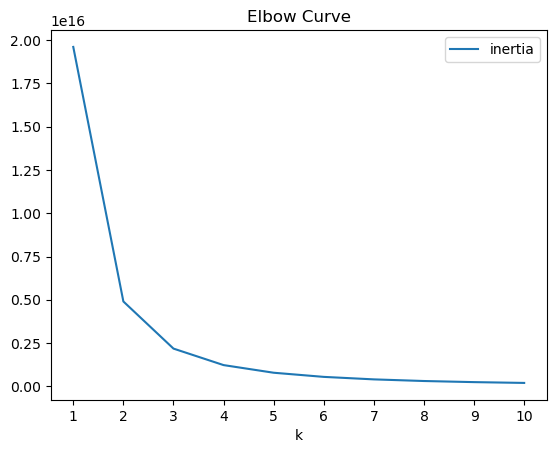

In [408]:
# Plot the Elbow curve
df_elbow.plot.line(x="k",
                   y="inertia",
                   title="Elbow Curve",
                   xticks=k)

### Run KMeans Model with k=3

In [409]:
# Create and initialize the K-Means model and instance for 3 clusters
model = KMeans(n_clusters=3, n_init='auto', random_state=42)

#Print the Model
model

KMeans(n_clusters=3, random_state=42)

In [411]:
# Fit the data to the instance of the model
model.fit(X_train_encoded, y_train)

KMeans(n_clusters=3, random_state=42)

In [413]:
# Make predictions about the data clusters using the trained model
flight_predictions = model.predict(X_test_encoded)

# Print the predictions
print(balanced_accuracy_score(y_test_encoded, y_test_pred))

0.49784150866732296


In [414]:
# Check the model's balanced accuracy on the training set

y_train_pred = model.predict(X_train_encoded)
print(balanced_accuracy_score(y_train_encoded, y_train_pred))

0.2832969759220692


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [415]:
# We overfit! Lets try varying the max depth

models = {'train_score': [], 'test_score': [], 'max_depth': []}

for depth in range(1,10):
    models['max_depth'].append(depth)
    model = RandomForestClassifier(n_estimators=500, max_depth=depth)
    model.fit(X_train_encoded, y_train_encoded)
    y_test_pred = model.predict(X_test_encoded)
    y_train_pred = model.predict(X_train_encoded)

    models['train_score'].append(balanced_accuracy_score(y_train_encoded, y_train_pred))
    models['test_score'].append(balanced_accuracy_score(y_test_encoded, y_test_pred))

models_df = pd.DataFrame(models)

In [ ]:
models_df.plot(x='max_depth')

In [295]:
# Create a copy of the DataFrame
X_train_encoded = X_train_encoded.copy()

#Add a column to the dataframe that contains the flight information
X_train_encoded['flight delay'] = flight_predictions

# Review the dataframe
X_train_encoded.head()



,index,id,Flight,DayOfWeek,Time,Length,x0,x0,x0,airline,From,To,flight delay
0,2972,2973,2056,3,490,113,0.0,0.0,0.0,0.0,0.0,43.0,1
1,427072,427073,399,6,935,156,1.0,0.0,1.0,1.0,0.0,43.0,2
2,514888,514889,4592,4,810,165,2.0,1.0,2.0,2.0,1.0,18.0,2
3,127314,127315,2916,3,701,168,0.0,2.0,3.0,0.0,2.0,52.0,1
4,139613,139614,963,4,420,102,3.0,3.0,4.0,3.0,3.0,13.0,1


<Axes: xlabel='Time', ylabel='DayOfWeek'>

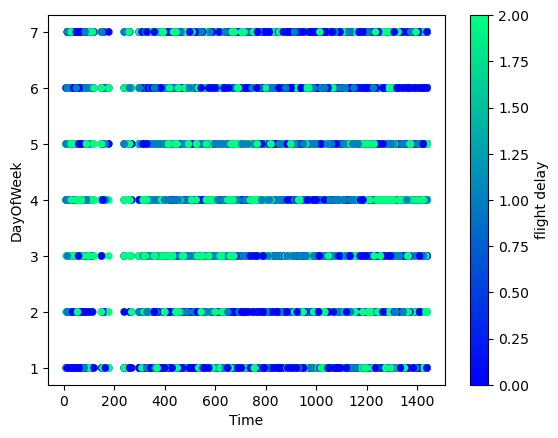

In [296]:
# Plot the data points based on the customer rating
X_train_encoded.plot.scatter(
    x="Time", 
    y="DayOfWeek",
    c="flight delay", 
    colormap='winter')